# AI in Industry project
# Flare prediction
- Ildebrando Simeoni - ildebrando.simeoni@studio.unibo.it
- Davide Femia - davide.femia@studio.unibo.it
- Riccardo Falco - riccardo.falco2@tudio.unibo.it
- Vincenzo Collura - vincenzo.collura2@studio.unibo.it


##The problem

Given the problem of flare prediction and the data obtained from the data inspection notebook a restructuring of the problem has been performed.

Namely, the problem of flare prediction has been transformed into a binary classification problem. Given a window of time series values of fixed size the probability of incurring into a flare in the next one is computed. To each window a label is assigned, in particular 0 if the window is not followed by a flare window (i.e. a window that contains a number higher than a manually selected threshold of flares/anomalies), 1 otherwise.

## Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

from Libs.load_data import DataLoader, get_dataset_split
import Libs.flares_plot as fplt
from Libs.threshold import get_labels_physic, get_labels_KDE, get_labels_quantile, get_labels_quantile_on_run
from Libs.keras_f1score import f1_m
from Libs.config import models_data_folder

import numpy as np
import pandas as pd
import os
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, auc, roc_curve

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.initializers import Constant

2023-03-20 12:52:21.123387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 12:52:21.281900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 12:52:21.281928: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 12:52:22.572764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Dataframe building

The dataset used for all the experiments has been computed as shown in the data inspection notebook. In particular here we leveraged the advantages of the synthetic dataset by incrementing the number of runs of a pre defined set of parameters (shown below) that were considered pyhisically reasonable in the original paper

In [ ]:
data_loader = DataLoader(run=100, N=1000, s=0.5, t=0.01, d=0.2, m=1, override=False, folder=models_data_folder)
params = data_loader.get_params()
params

{'run': 100,
 'sigma': [0.5],
 'theta': [0.01],
 'mu': [1],
 'delta': [0.2],
 'N': 1000}

In [ ]:
Xs, best_labels = data_loader.get_grid()

A fixed window size and overlap have been selected for all the experiments, allowing to compare results among different models.

The train, val and test split of the time series was performed over separated runs, in order to avoid any data leakage between training and testing models.

The manually selected threshold to define the window as a flare window has been selected as 1, this choice can be reviewed by simply change a parameter in the dataframe definition.

In [ ]:
dataset_split_params = {
    'window_size': 20, # how large is the window
    'overlap_size': 19, # how many time interval of overlap there is between the windows
    'label_treshold': 1, # how many labels have to be at 1 in the window_size to consider the current window as a flare
    'split_on_run': True, # if True the windows of a run cannot be on different sets
    'shuffle_run': False, # if True shuffles the order of the runs before computing the windows
    'shuffle_window': False, # if True shuffles the order of the windows in the resulting dataframes
    'test_size': 0.3, # size of the test set expressed in percentage
    'val_size': 0.2, # size of the validation set expressed in percentage, considered only if get_validation is True
    'get_validation': True, # if True the output would be train,val,test set, otherwise it would be train,test
    'random_state': 42 # sets the seed for reproducibility
}
df_train, df_val, df_test = get_dataset_split(Xs, best_labels, **dataset_split_params)
df_train

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,0.798931,0.583646,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,...,0.351799,0.391335,0.446848,0.293677,0.298714,0.280781,0.209521,0.256383,0.307991,0
1,0.975000,0.798931,0.583646,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,0.344712,...,0.391335,0.446848,0.293677,0.298714,0.280781,0.209521,0.256383,0.307991,0.228228,0
2,0.798931,0.583646,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,0.344712,0.351799,...,0.446848,0.293677,0.298714,0.280781,0.209521,0.256383,0.307991,0.228228,0.187999,0
3,0.583646,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,0.344712,0.351799,0.391335,...,0.293677,0.298714,0.280781,0.209521,0.256383,0.307991,0.228228,0.187999,0.145653,0
4,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,0.344712,0.351799,0.391335,0.446848,...,0.298714,0.280781,0.209521,0.256383,0.307991,0.228228,0.187999,0.145653,0.135238,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48015,0.100721,0.133561,0.153607,0.256644,0.301407,0.250394,0.237981,0.261486,0.303675,0.336200,...,0.207898,0.159825,0.155198,0.197111,0.189724,0.124323,0.201641,0.252559,0.395413,0
48016,0.133561,0.153607,0.256644,0.301407,0.250394,0.237981,0.261486,0.303675,0.336200,0.207536,...,0.159825,0.155198,0.197111,0.189724,0.124323,0.201641,0.252559,0.395413,0.315961,0
48017,0.153607,0.256644,0.301407,0.250394,0.237981,0.261486,0.303675,0.336200,0.207536,0.207898,...,0.155198,0.197111,0.189724,0.124323,0.201641,0.252559,0.395413,0.315961,0.345996,0
48018,0.256644,0.301407,0.250394,0.237981,0.261486,0.303675,0.336200,0.207536,0.207898,0.159825,...,0.197111,0.189724,0.124323,0.201641,0.252559,0.395413,0.315961,0.345996,0.371824,0


In [ ]:
df_val

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,1.049886,0.709235,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,...,0.564956,0.422026,0.396772,0.345643,0.431470,0.431736,0.357961,0.559436,0.549288,0
1,0.975000,1.049886,0.709235,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,0.552614,...,0.422026,0.396772,0.345643,0.431470,0.431736,0.357961,0.559436,0.549288,0.444852,0
2,1.049886,0.709235,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,0.552614,0.564956,...,0.396772,0.345643,0.431470,0.431736,0.357961,0.559436,0.549288,0.444852,0.560786,0
3,0.709235,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,0.552614,0.564956,0.422026,...,0.345643,0.431470,0.431736,0.357961,0.559436,0.549288,0.444852,0.560786,0.640663,0
4,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,0.552614,0.564956,0.422026,0.396772,...,0.431470,0.431736,0.357961,0.559436,0.549288,0.444852,0.560786,0.640663,0.652257,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20575,0.052285,0.048019,0.071015,0.049237,0.052889,0.051587,0.057016,0.064530,0.066676,0.086608,...,0.094474,0.180342,0.265600,0.236947,0.265520,0.262787,0.237580,0.318366,0.250948,0
20576,0.048019,0.071015,0.049237,0.052889,0.051587,0.057016,0.064530,0.066676,0.086608,0.094120,...,0.180342,0.265600,0.236947,0.265520,0.262787,0.237580,0.318366,0.250948,0.151192,0
20577,0.071015,0.049237,0.052889,0.051587,0.057016,0.064530,0.066676,0.086608,0.094120,0.094474,...,0.265600,0.236947,0.265520,0.262787,0.237580,0.318366,0.250948,0.151192,0.119847,0
20578,0.049237,0.052889,0.051587,0.057016,0.064530,0.066676,0.086608,0.094120,0.094474,0.180342,...,0.236947,0.265520,0.262787,0.237580,0.318366,0.250948,0.151192,0.119847,0.097869,0


In [ ]:
df_test

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,0.956607,0.750944,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,...,0.503110,0.571377,0.571170,0.347337,0.337584,0.211312,0.207977,0.233514,0.319375,0
1,0.975000,0.956607,0.750944,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,0.462558,...,0.571377,0.571170,0.347337,0.337584,0.211312,0.207977,0.233514,0.319375,0.198887,0
2,0.956607,0.750944,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,0.462558,0.503110,...,0.571170,0.347337,0.337584,0.211312,0.207977,0.233514,0.319375,0.198887,0.159106,0
3,0.750944,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,0.462558,0.503110,0.571377,...,0.347337,0.337584,0.211312,0.207977,0.233514,0.319375,0.198887,0.159106,0.110544,0
4,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,0.462558,0.503110,0.571377,0.571170,...,0.337584,0.211312,0.207977,0.233514,0.319375,0.198887,0.159106,0.110544,0.124472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,0.088472,0.079050,0.127112,0.124727,0.123249,0.134629,0.152770,0.194376,0.148435,0.154884,...,0.224690,0.133206,0.122031,0.089321,0.082637,0.110813,0.104113,0.176562,0.172137,0
29396,0.079050,0.127112,0.124727,0.123249,0.134629,0.152770,0.194376,0.148435,0.154884,0.235067,...,0.133206,0.122031,0.089321,0.082637,0.110813,0.104113,0.176562,0.172137,0.148510,0
29397,0.127112,0.124727,0.123249,0.134629,0.152770,0.194376,0.148435,0.154884,0.235067,0.224690,...,0.122031,0.089321,0.082637,0.110813,0.104113,0.176562,0.172137,0.148510,0.165008,0
29398,0.124727,0.123249,0.134629,0.152770,0.194376,0.148435,0.154884,0.235067,0.224690,0.133206,...,0.089321,0.082637,0.110813,0.104113,0.176562,0.172137,0.148510,0.165008,0.277899,0


As expected the problem in hand, being an anomaly detection problem, is an heavily unbalanced binary problem with a much higher presence of class 0 (i.e. non flares) windows.

Several ways to take that into account have been later performed in different models

In [ ]:
# number of classes
print('Training set:')
train_counts = df_train['future_flare'].value_counts()
print(train_counts, '\n')
print('validation set:')
val_counts = df_val['future_flare'].value_counts()
print(val_counts, '\n')
print('Test set:')
test_counts = df_test['future_flare'].value_counts()
print(test_counts, '\n')
print('Total:')
total_counts = train_counts.add(val_counts).add(test_counts)
print(total_counts, '\n')


Training set:
0    42573
1     5447
Name: future_flare, dtype: int64 

validation set:
0    18776
1     1804
Name: future_flare, dtype: int64 

Test set:
0    26320
1     3080
Name: future_flare, dtype: int64 

Total:
0    87669
1    10331
Name: future_flare, dtype: int64 



In [ ]:
X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()
X_train_val, y_train_val = np.vstack((X_train, X_val)), np.hstack((y_train, y_val))
X, y = np.vstack((X_train, X_val, X_test)), np.hstack((y_train, y_val, y_test))
print('X ## Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape, 'Total', X.shape)
print('y ## Train:', y_train.shape, '   Val:', y_val.shape, '   Test:', y_test.shape, '   Total', y.shape)

X ## Train: (48020, 20) Val: (20580, 20) Test: (29400, 20) Total (98000, 20)
y ## Train: (48020,)    Val: (20580,)    Test: (29400,)    Total (98000,)


## Models
In the following cells, a variety of models has been tested on the aforementioned problem, obtaining results over F1 and AUC metrics. 

Starting from simpler models (e.g. DT, SVM) we also wanted to include some more sophisticated solutions for Time Series analysis, which include CNN and LSTM models.


### Simple models
A pletora of simpler models have been tested with a cross-validation approach with hyper parameter tuning performed over the validation set. In particular SVM has been provided with class weights in order to deal with the intrinsically unbalanced problem in hand

In [ ]:
model_lbls = ['dt', 'nb', 'lp', 'svc', 'knn']

class_weights = {0:1, 1:5}

# Set the parameters to be explored by the grid for each classifier
tuned_param_dt = [{'max_depth': list(range(1,20))}]
tuned_param_nb = [{'var_smoothing': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-07, 1e-8, 1e-9, 1e-10]}]
tuned_param_lp = [{'early_stopping': [True]}]
tuned_param_svc = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000], 'class_weight':[class_weights]},
                   
                   
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight':[class_weights]}]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]


# set the models to be fitted specifying name, estimator and parameter structure
models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': tuned_param_nb
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(),
           'param': tuned_param_lp,
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
          }
}

# scores to be explored
scores = ['f1_macro']

In [ ]:
def print_results(model):
    print("Best parameters set found on train_val set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train_val set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train_val set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    print('AUC:', auc(fpr, tpr))
    print()

In [ ]:
results_short = {}
cv_results = []
models_override = False
models_folder = os.path.join("models",f"overlap_{dataset_split_params['overlap_size']}")
for score in scores:
    print('='*40)
    print("# Tuning hyper-parameters for %s" % score)
    print()
    s_result = []
    for m in model_lbls:
        print('-'*40)
        print("Trying model {}".format(models[m]['name']))
        model_path = os.path.join(models_folder, f"{score}_{m}.pkl")
        if (not os.path.exists(model_path)) or models_override:
            clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s' % score,
                               return_train_score = False,
                               n_jobs = 2, # this allows using multi-cores
                               )
            clf.fit(X_train_val, y_train_val)
            joblib.dump(clf, model_path)
        else:
            clf = joblib.load(model_path)
        print_results(clf)
        s_result.append(clf)
        results_short[m] = clf.best_score_
    cv_results.append(s_result)
    print("Summary of results for {}".format(score))
    print("Estimator")
    for m in results_short.keys():
        print("{}\t - score: {:5.2f}%".format(models[m]['name'], results_short[m]*100))

# Tuning hyper-parameters for f1_macro

----------------------------------------
Trying model Decision Tree       
Best parameters set found on train_val set:

{'max_depth': 15}

Grid scores on train_val set:

0.915 (+/-0.026) for {'max_depth': 1}
0.938 (+/-0.020) for {'max_depth': 2}
0.956 (+/-0.018) for {'max_depth': 3}
0.966 (+/-0.015) for {'max_depth': 4}
0.971 (+/-0.016) for {'max_depth': 5}
0.977 (+/-0.012) for {'max_depth': 6}
0.980 (+/-0.011) for {'max_depth': 7}
0.982 (+/-0.009) for {'max_depth': 8}
0.984 (+/-0.008) for {'max_depth': 9}
0.985 (+/-0.008) for {'max_depth': 10}
0.986 (+/-0.007) for {'max_depth': 11}
0.985 (+/-0.006) for {'max_depth': 12}
0.985 (+/-0.006) for {'max_depth': 13}
0.986 (+/-0.006) for {'max_depth': 14}
0.986 (+/-0.005) for {'max_depth': 15}
0.986 (+/-0.005) for {'max_depth': 16}
0.986 (+/-0.005) for {'max_depth': 17}
0.986 (+/-0.006) for {'max_depth': 18}
0.986 (+/-0.006) for {'max_depth': 19}

Detailed classification report for the best parameter set

### CNN
As shown in the paper [\[2\]](https://arxiv.org/abs/1611.06455), one possible way to deal with time series classification is 1D FCN. The architecture proposed in the paper has been adapted for our problem and tested for the binary classification problem in hand

Data are standardized before being fed into both our CNN and LSTM models in order to let the models start with small values near 0 in the same range, allowing better initialization for the Gradient Descent process

In [ ]:
# Standardize Data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)
# Make the data uniform to multivariate timeseries
X_train_cnn = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_val_cnn = X_val_std.reshape((X_val_std.shape[0], X_val_std.shape[1], 1))
X_test_cnn = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))
# get automatically the number of classes
num_classes = len(np.unique(y))

In [ ]:
def make_model(input_shape, num_classes, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    if num_classes==2:
        output_layer = keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(gap)
    else:
        output_layer = keras.layers.Dense(num_classes, activation="softmax", bias_initializer=output_bias)(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

initial_bias = np.log([train_counts[1]/train_counts[0]])
cnn_model = make_model(input_shape=X_train_cnn.shape[1:], num_classes=num_classes, output_bias=initial_bias)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 20, 64)           256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 20, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 64)           256       
 hNormalization)                                             

2023-03-20 12:53:20.464496: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-20 12:53:20.464556: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-20 12:53:20.464582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5166cf34c918): /proc/driver/nvidia/version does not exist
2023-03-20 12:53:20.464881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 20, 64)            0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 25,793
Trainable params: 25,409
Non-trainable params: 384
_________________________________________________________________


In [ ]:
cnn_path = os.path.join(models_folder, "CNN_best_weights.h5")
override_cnn = False

if override_cnn:
    epochs = 500
    batch_size = 256
    callbacks = [
        keras.callbacks.ModelCheckpoint(cnn_path, save_weights_only=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)
    ]
    if num_classes==2:
        loss = keras.losses.BinaryCrossentropy()
    else:
        loss = "sparse_categorical_crossentropy"
    cnn_model.compile(
        optimizer="adam",
        loss=loss,
        metrics=[f1_m],
    )
    cnn_history = cnn_model.fit(
        X_train_cnn,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(X_val_cnn, y_val),
        verbose=1,
    )

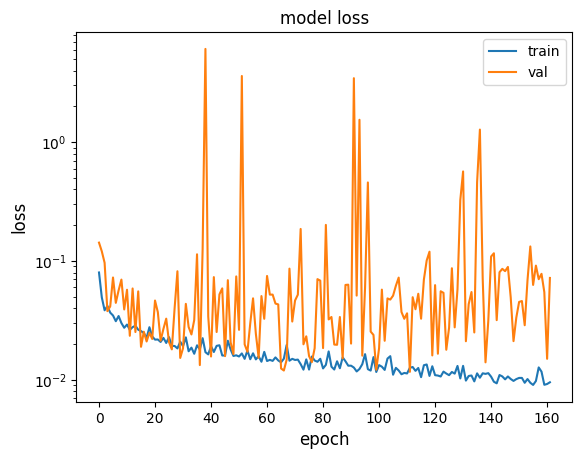

In [ ]:
import pickle
if override_cnn:
    metric = "loss"
    plt.figure()
    plt.plot(cnn_history.history[metric])
    plt.plot(cnn_history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.yscale('log')
    with open(os.path.join(models_folder, "CNN_plot.pickle"), 'wb') as f:
        fig = plt.gcf()
        pickle.dump(fig, f)
else:
    with open(os.path.join(models_folder, "CNN_plot.pickle"), 'rb') as f:
        fig = pickle.load(f)
fig.show()
    

In [ ]:
cnn_model = make_model(input_shape=X_train_cnn.shape[1:], num_classes=num_classes)
cnn_model.load_weights(cnn_path)
y_test_pred_cnn = np.round(cnn_model.predict(X_test_cnn), 0)
test_f1_macro_cnn = f1_score(y_test, y_test_pred_cnn, average='macro')
print("Test F1 Macro", test_f1_macro_cnn)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_test_pred_cnn, pos_label=1)
print('AUC:', auc(fpr_cnn, tpr_cnn))

919/919 [==============================] - 3s 3ms/step
Test F1 Macro 0.9352496160524308
AUC: 0.8949675324675325


### LSTM

The problem of sequence classification is difficult since the sequences can vary in length, comprise a very large vocabulary of input symbols. Thus it could be useful to require that the model to learn the long-term context or dependencies between symbols in the input sequence.

For this reason we will explore also the application of LSTM (_Long Short-Term Memory_) recurrent neural network. More precisly we decided to implement a bi-LSTM (_bidirectional LSTM_), taking inspiration from previous work in similar topics like in [\[3\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta) and [\[4\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta).

Indeed, sometimes combining forward and reversed time serie could give better results.

Similarly to CNN case the last dense layer will be properly initialized.

In [ ]:
# define model
def make_lstm(input_shape, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    lstm_model = Sequential()
    lstm_model.add(Bidirectional(LSTM(20, activation='relu'), input_shape=input_shape))
    lstm_model.add(Dense(30, activation='relu'))
    lstm_model.add(Dense(10, activation='relu'))
    lstm_model.add(Dense(1, activation='sigmoid',bias_initializer=output_bias))
    return lstm_model

initial_bias = np.log([train_counts[1]/train_counts[0]])
lstm_model = make_lstm((X_train_std.shape[1], 1), output_bias=initial_bias)
lstm_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m, 'accuracy'])

print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 40)               3520      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 30)                1230      
                                                                 
 dense_3 (Dense)             (None, 10)                310       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
None


For the porpose of training this time, it will be not requested a great amount of epochs and no particular streanght is required to have good results in fitting the model.

Also in this case as previously done in CNN, we are going to use a the standardize dataset.

In [ ]:
lstm_path = os.path.join(models_folder, "LSTM_best_weights.h5")
override_lstm = False

if override_lstm:
    epochs = 20
    batch_size = 32
    # define callbacks
    callbacks = [
        ModelCheckpoint(lstm_path, save_weights_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    ]
    # fit model
    lstm_history = lstm_model.fit(
        X_train_std,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(X_val_std, y_val),
        verbose=1,
    )

The plot below shows that the model is performing good also in validation set which is indeed a good sanity check of fit well performed and very rapidely. Moreover at the starting epoch, the loss value seems to be much more lower than respect to the loss of the worst classifier (i.e. random classifier) having loss $\log(2)$, which is extremely promising.

The plot and the auxiliary callback EarlyStopping allow to control the model avoiding to fall in overfitting, which is known to be a common problem for all ANNs models and in particular for LSTM. By the way this don't seems to be our case.

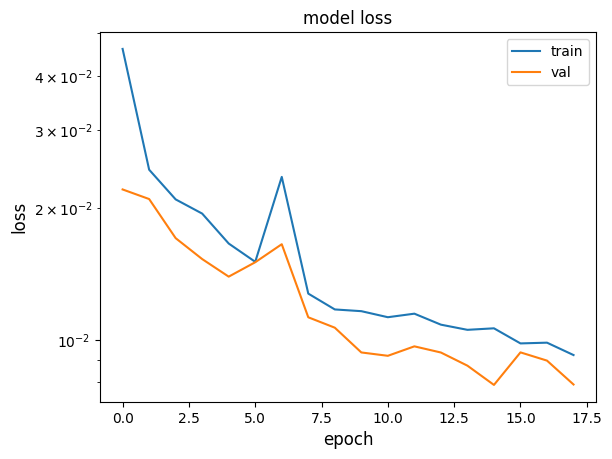

In [ ]:
import matplotlib.pyplot as plt
if override_lstm:
    metric = "loss"
    plt.figure()
    plt.plot(lstm_history.history[metric])
    plt.plot(lstm_history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.yscale('log')
    with open(os.path.join(models_folder, "LSTM_plot.pickle"), 'wb') as f:
        fig = plt.gcf()
        pickle.dump(fig, f)
else:
    with open(os.path.join(models_folder, "LSTM_plot.pickle"), 'rb') as f:
        fig = pickle.load(f)
fig.show()

Finally results show the effectiveness of this model under the f1 score metric and auc metric.

In [ ]:
lstm_model = make_lstm((X_train_std.shape[1], 1))
lstm_model.load_weights(lstm_path)
y_test_pred_lstm = np.round(lstm_model.predict(X_test_std), 0)

print("### Evaluation on test set ###")
print("F1 Macro score: %.2f" % (f1_score(y_test, y_test_pred_lstm, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_test_pred_lstm)
print(result)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_test_pred_lstm, pos_label=1)
print('AUC:', auc(fpr_lstm, tpr_lstm))


919/919 [==============================] - 4s 4ms/step
### Evaluation on test set ###
F1 Macro score: 0.99
[[26255    65]
 [   31  3049]]
AUC: 0.9937327300359216


# Bibliography
\[1\] _On the distribution of fluxes of gamma-ray blazars: hints for a stochastic process?_, Tavecchio et al., [https://arxiv.org/pdf/2004.09149.pdf](https://arxiv.org/pdf/2004.09149.pdf)
<!-- cite with: [\[1\]](https://arxiv.org/pdf/2004.09149.pdf)  -->
\[2\] _Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline_, Wang et al., [https://arxiv.org/abs/1611.06455](https://arxiv.org/abs/1611.06455)
<!-- cite with: [\[2\]](https://arxiv.org/abs/1611.06455)  -->
\[3\] _Solar Flare Prediction Based on the Fusion of Multiple Deep-learning Models_, Tang et al., [https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta)
<!-- cite with: [\[3\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta)  -->
\[4\] _Predicting Solar Energetic Particles Using SDO/HMI Vector Magnetic Data Products and a Bidirectional LSTM Network_, Abduallah et al., [https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta)
<!-- cite with: [\[4\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta) -->